# Example of usage Spark OCR for extract metadata from Dicom document

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar`
- or `secret` for Spark OCR
- `aws_access_key` and `aws_secret_key`for download pretrained models

For more details about Dicom de-identification please read:

 - [DICOM de-identification at scale in Visual NLP — Part 1.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-1-68784177f5f0)

 - [DICOM de-identification at scale in Visual NLP — Part 2.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-2-361af5e36412)

 - [DICOM de-identification at scale in Visual NLP — Part 3.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-3-ac750be386cb)

In [1]:
license = ""
secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

In [2]:
# install from PYPI using secret
#%pip install spark-ocr==$version --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
#%pip install highdicom

In [3]:
#%pip install ../../../python/dist/spark-ocr-4.2.1.tar.gz

## Initialization of spark session

In [ ]:
from sparkocr import start
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key


spark = start(secret=secret,
              jar_path=spark_ocr_jar_path)

spark

## Import Spark OCR transformers

In [3]:
import pandas as pd

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *
import pyspark.sql.functions as f

from pyspark.ml import PipelineModel, Pipeline

## Define OCR transformers and pipeline

In [4]:
# Distribute images from Dicom(multiframe) to the few partitions
dicom = DicomToMetadata() \
    .setInputCol("content") \
    .setOutputCol("metadata")

## Read dicom objects as binary file and display metadata


In [5]:
import pkg_resources
dicom_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/dicoms/*')
dicom_df = spark.read.format("binaryFile").load(dicom_path)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Let's look to the number and size of the documents in Mb

In [6]:
dicom_df.select(f.col("length") / 10**6).summary().show()

+-------+------------------+
|summary|(length / 1000000)|
+-------+------------------+
|  count|                 4|
|   mean|         0.6922585|
| stddev|0.2599794587545972|
|    min|          0.426776|
|    25%|          0.426776|
|    50%|          0.640574|
|    75%|          0.651696|
|    max|          1.049988|
+-------+------------------+



## Show dicom

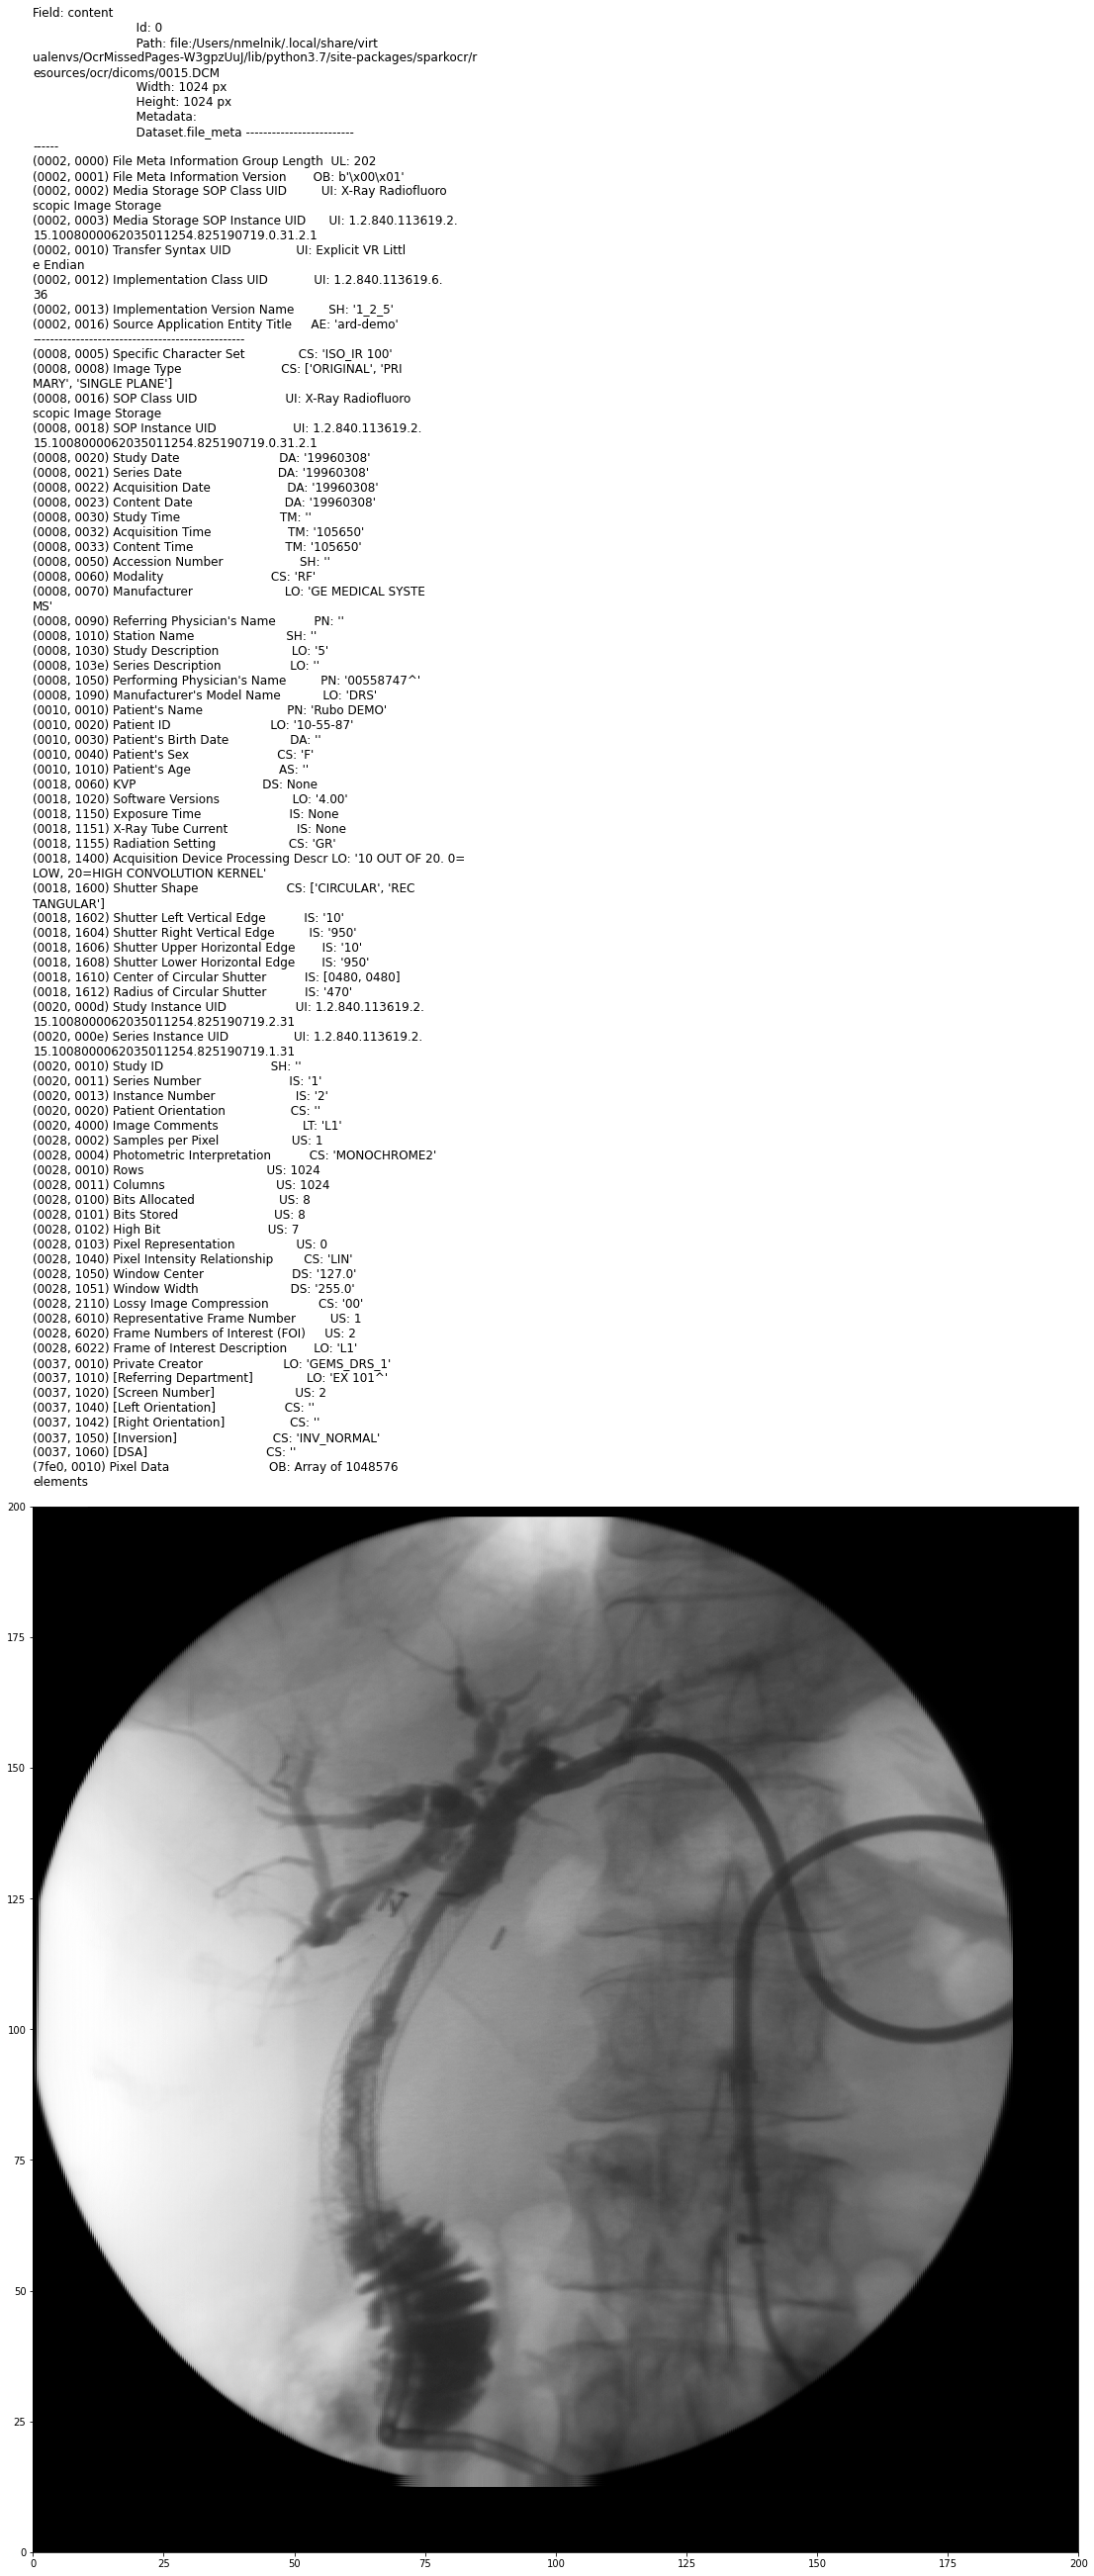

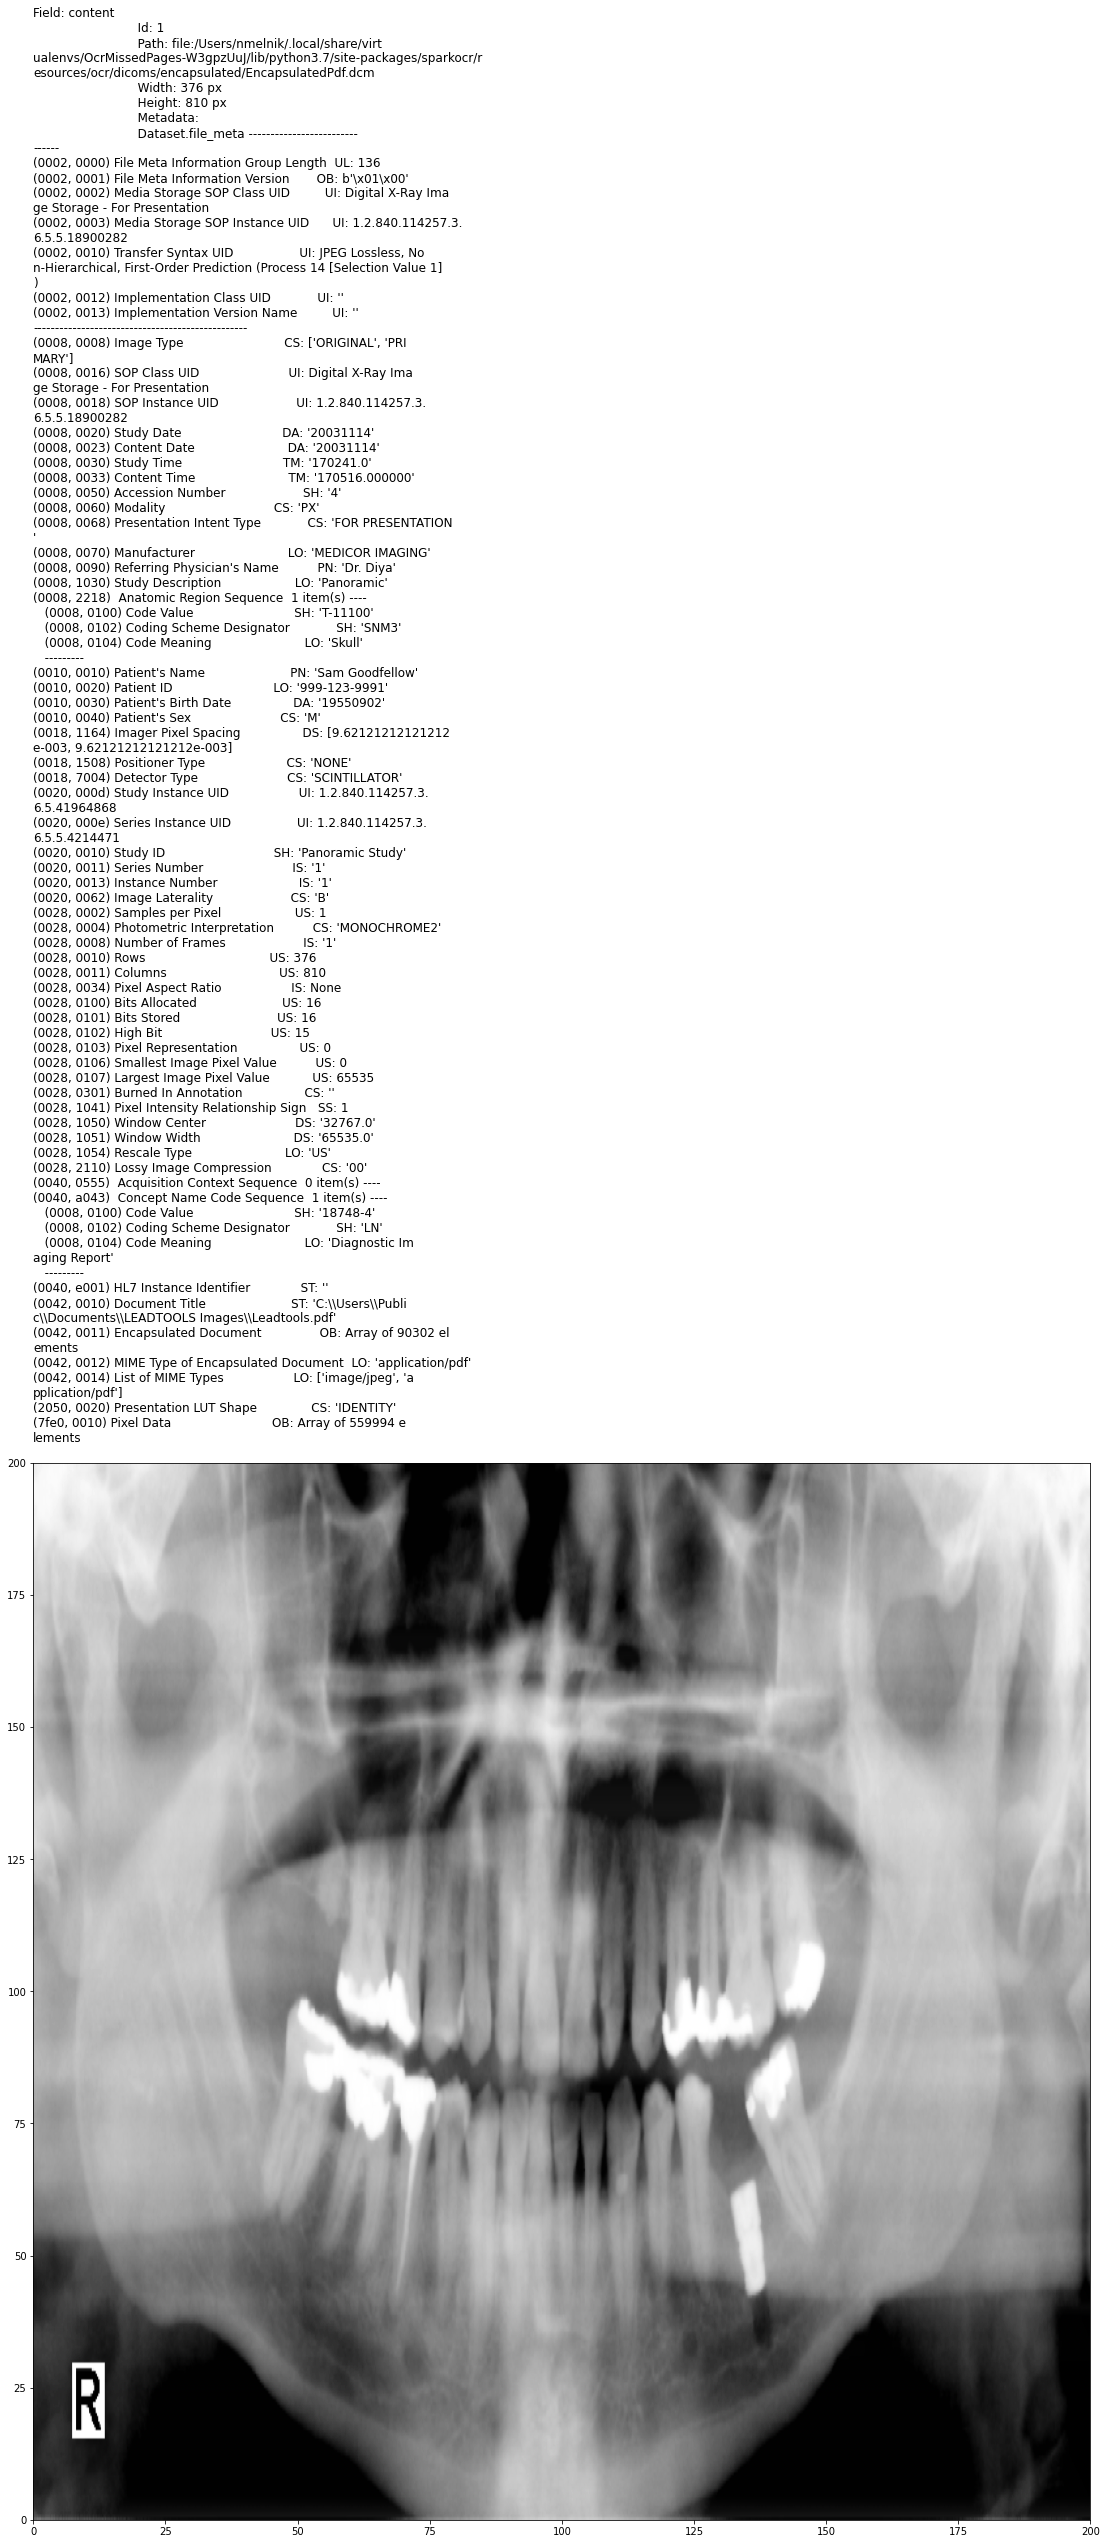

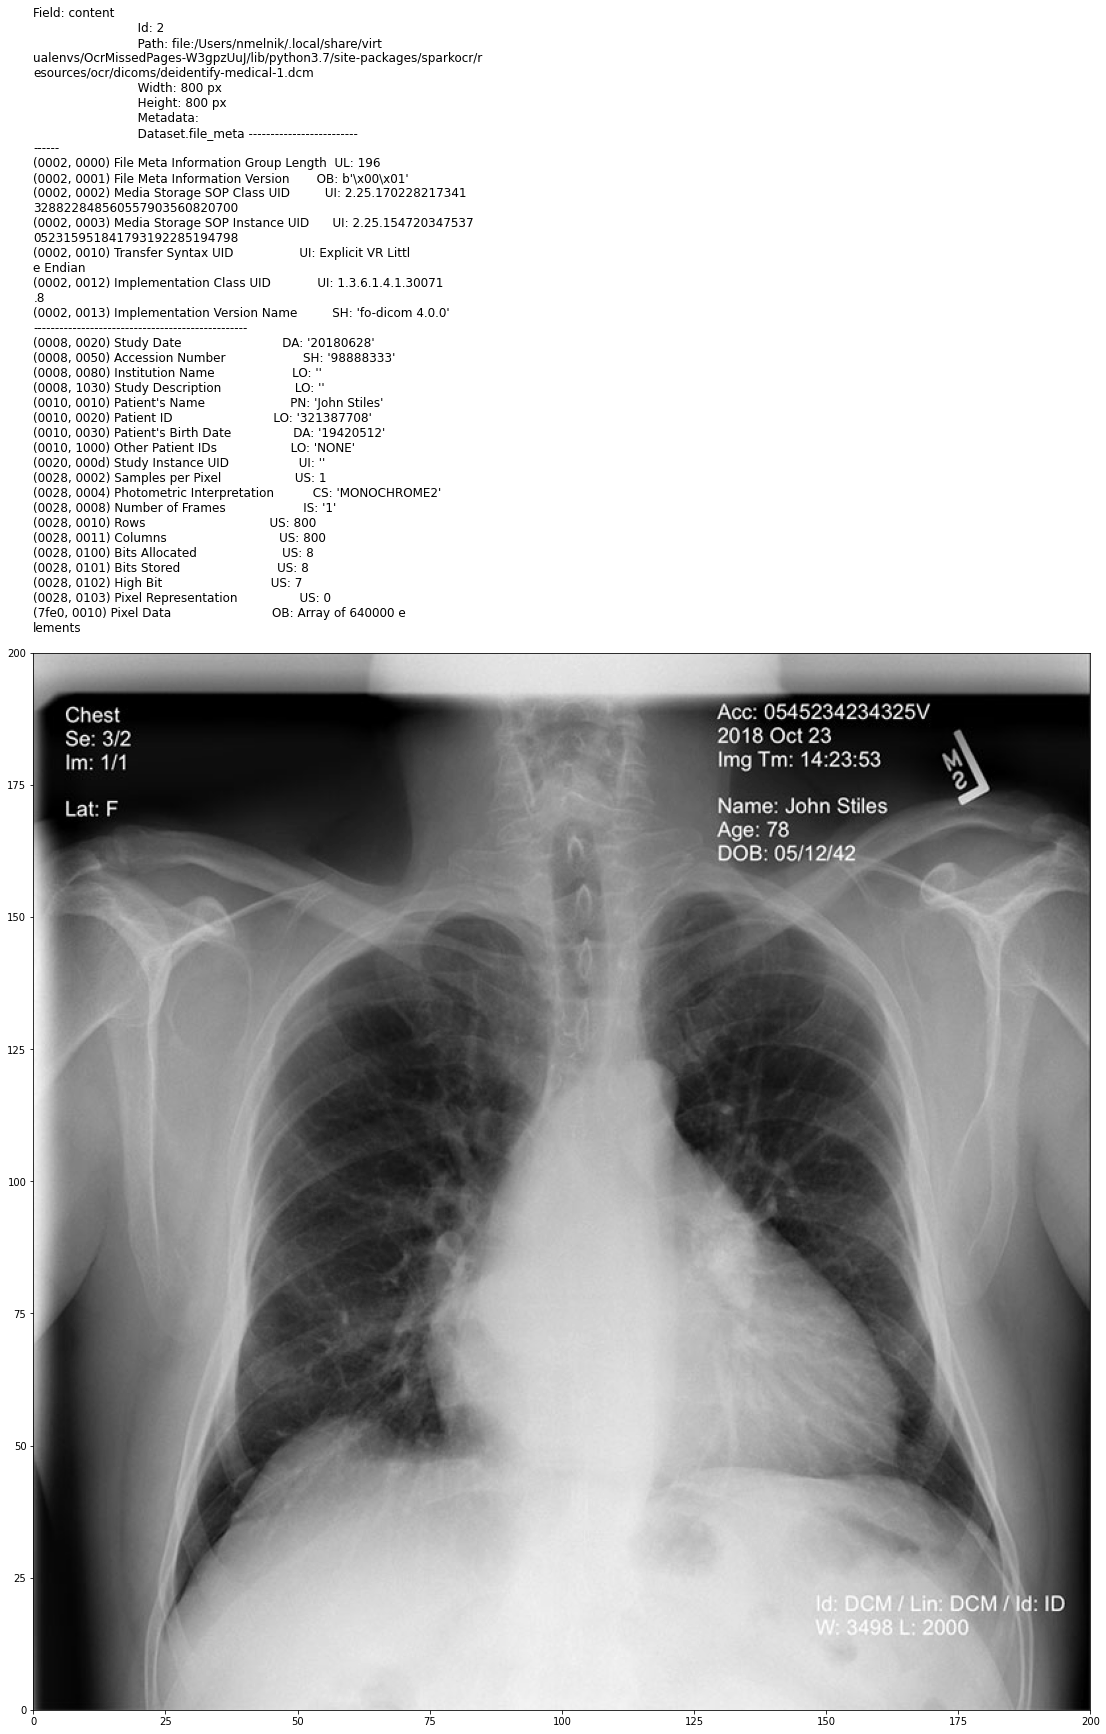

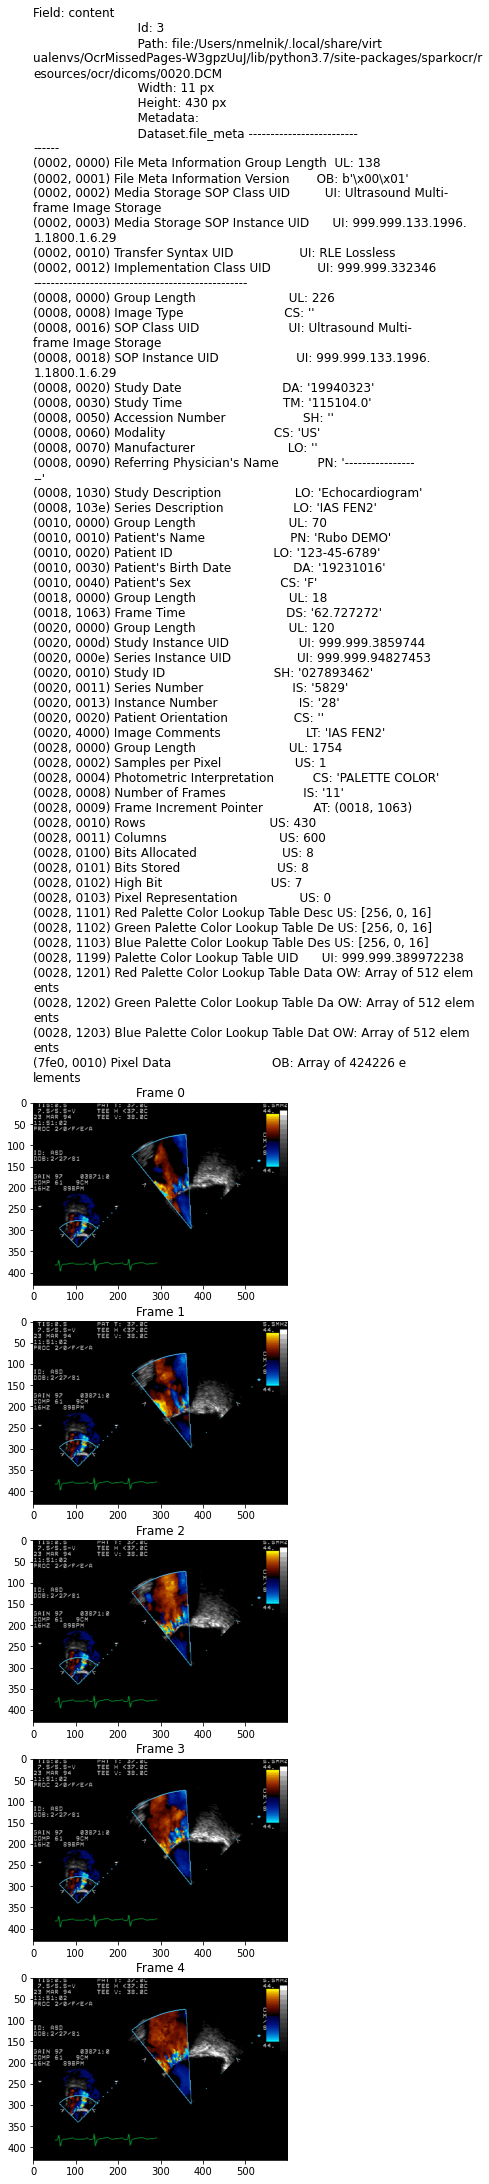

In [7]:
display_dicom(dicom_df, "content")

## Read matadata of dicom document to the dataframe
'metadata' column will contains it as a string

In [8]:
result = dicom.transform(dicom_df)
result

path,modificationTime,length,metadata
file:/Users/nmeln...,2023-11-16 18:39:21,1049988,"{\n ""SpecificC..."
file:/Users/nmeln...,2023-11-16 18:39:22,651696,"{\n ""ImageType..."
file:/Users/nmeln...,2023-11-16 18:39:22,640574,"{\n ""StudyDate..."
file:/Users/nmeln...,2023-11-16 18:39:22,426776,"{\n ""GroupLeng..."


### Let's read it as the json using spark capabilities

In [9]:
json_schema = spark.read.json(result.rdd.map(lambda row: row.metadata)).schema
metadata = result.select(f.from_json('metadata', json_schema).alias("metadata"))
metadata.select("metadata.*")

AccessionNumber,AcquisitionContextSequence,AcquisitionDate,AcquisitionDeviceProcessingDescription,AcquisitionTime,AnatomicRegionSequence,BitsAllocated,BitsStored,BluePaletteColorLookupTableData,BluePaletteColorLookupTableDescriptor,BurnedInAnnotation,CenterofCircularShutter,Columns,ConceptNameCodeSequence,ContentDate,ContentTime,DetectorType,DocumentTitle,EncapsulatedDocument,ExposureTime,FrameIncrementPointer,FrameNumbersofInterest(FOI),FrameTime,FrameofInterestDescription,GreenPaletteColorLookupTableData,GreenPaletteColorLookupTableDescriptor,GroupLength,HL7InstanceIdentifier,HighBit,ImageComments,ImageLaterality,ImageType,ImagerPixelSpacing,InstanceNumber,InstitutionName,KVP,LargestImagePixelValue,ListofMIMETypes,LossyImageCompression,MIMETypeofEncapsulatedDocument,Manufacturer,Manufacturer'sModelName,Modality,NumberofFrames,OtherPatientIDs,PaletteColorLookupTableUID,Patient'sAge,Patient'sBirthDate,Patient'sName,Patient'sSex,PatientID,PatientOrientation,PerformingPhysician'sName,PhotometricInterpretation,PixelAspectRatio,PixelIntensityRelationship,PixelIntensityRelationshipSign,PixelRepresentation,PositionerType,PresentationIntentType,PresentationLUTShape,PrivateCreator,RadiationSetting,RadiusofCircularShutter,RedPaletteColorLookupTableData,RedPaletteColorLookupTableDescriptor,ReferringPhysician'sName,RepresentativeFrameNumber,RescaleType,Rows,SOPClassUID,SOPInstanceUID,SamplesperPixel,SeriesDate,SeriesDescription,SeriesInstanceUID,SeriesNumber,ShutterLeftVerticalEdge,ShutterLowerHorizontalEdge,ShutterRightVerticalEdge,ShutterShape,ShutterUpperHorizontalEdge,SmallestImagePixelValue,SoftwareVersions,SpecificCharacterSet,StationName,StudyDate,StudyDescription,StudyID,StudyInstanceUID,StudyTime,WindowCenter,WindowWidth,X-RayTubeCurrent,[DSA],[Inversion],[LeftOrientation],[ReferringDepartment],[RightOrientation],[ScreenNumber]
,null,19960308,10 OUT OF 20. 0=L...,105650,null,8,8,null,null,null,"[0480, 0480]",1024,null,19960308,105650,null,null,null,None,null,2,null,L1,null,null,null,null,7,L1,null,"['ORIGINAL', 'PRI...",null,02,null,None,null,null,00,null,GE MEDICAL SYSTEMS,DRS,RF,null,null,null,,,Rubo DEMO,F,10-55-87,,00558747^,MONOCHROME2,null,LIN,null,0,null,null,null,GEMS_DRS_1,GR,0470,null,null,,1,null,1024,1.2.840.10008.5.1...,1.2.840.113619.2....,1,19960308,,1.2.840.113619.2....,01,10,0950,0950,"['CIRCULAR', 'REC...",10,null,4.00,ISO_IR 100,,19960308,5,,1.2.840.113619.2....,,127,255,None,,INV_NORMAL,,EX 101^,,2
4,[],null,null,null,"[{Skull, T-11100,...",16,16,null,null,,null,810,[{Diagnostic Imag...,20031114,170516.000000,SCINTILLATOR,C:\Users\Public\D...,b'%PDF-1.5\n%\xc7...,null,null,null,null,null,null,null,null,,15,null,B,"['ORIGINAL', 'PRI...",[9.62121212121212...,1,null,null,65535,"['image/jpeg', 'a...",00,application/pdf,MEDICOR IMAGING,null,PX,1,null,null,null,19550902,Sam Goodfellow,M,999-123-9991,null,null,MONOCHROME2,None,null,1,0,NONE,FOR PRESENTATION,IDENTITY,null,null,null,null,null,Dr. Diya,null,US,376,1.2.840.10008.5.1...,1.2.840.114257.3....,1,null,null,1.2.840.114257.3....,1,null,null,null,null,null,0,null,null,null,20031114,Panoramic,Panoramic Study,1.2.840.114257.3....,170241.0,32767.,65535.,null,null,null,null,null,null,null
98888333,null,null,null,null,null,8,8,null,null,null,null,800,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,7,null,null,null,null,null,,null,null,null,null,null,null,null,null,1,NONE,null,null,19420512,John Stiles,null,321387708,null,null,MONOCHROME2,null,null,null,0,null,null,null,null,null,null,null,null,null,null,null,800,null,null,1,null,null,null,null,null,null,null,null,null,null,null,null,null,20180628,,null,,null,null,null,null,null,null,null,null,null,null
,null,null,null,null,null,8,8,b'\x00\x00\x00\x0...,"[256, 0, 16]",null,null,600,null,null,null,null,null,null,null,"(0018, 1063)",null,62.727272,null,b'\x00\x00\x00\x0...,"[256, 0, 16]",1754,null,7,IAS FEN2,null,,null,28,null,null,null,null,null,null,,null,US,11,null,999.999.389972238,null,1

### Transpose dataframe for make it more readable

In [12]:
pd.set_option('display.max_rows', None)
metadata.select("metadata.*").toPandas().T

,0,1,2,3
AccessionNumber,,4,98888333,
AcquisitionContextSequence,None,[],None,None
AcquisitionDate,19960308,None,None,None
AcquisitionDeviceProcessingDescription,"10 OUT OF 20. 0=LOW, 20=HIGH CONVOLUTION KERNEL",None,None,None
AcquisitionTime,105650,None,None,None
AnatomicRegionSequence,None,"[(Skull, T-11100, SNM3)]",None,None
BitsAllocated,8,16,8,8
BitsStored,8,16,8,8
BluePaletteColorLookupTableData,None,None,None,b'\x00\x00\x00\x02\x00\x04\x00\x07\x00\n\x00\x...
BluePaletteColorLookupTableDescriptor,None,None,None,"[256, 0, 16]"


## Let's look to the number of frames per file

In [13]:
metadata.select(f.col("metadata.NumberofFrames").alias("NumberOfFrames").cast("int")).na.fill(1).summary()

summary,NumberOfFrames
count,4
mean,3.5
stddev,5.0
min,1
25%,1
50%,1
75%,1
max,11


## Get statistic about size (width) of the image in dicom
This can be useful for estimate time/resources needed for process dataset

In [14]:
metadata.select(f.col("metadata.Rows").alias("NumberOfFrames").cast("int")).summary()

summary,NumberOfFrames
count,4
mean,657.5
stddev,308.5595566499278
min,376
25%,376
50%,430
75%,800
max,1024


## Total number of frames

In [15]:
metadata.select(f.col("metadata.NumberofFrames").alias("NumberOfFrames").cast("int").alias("frames")) \
    .fillna(1) \
    .groupBy() \
    .sum()

sum(frames)
14


## Aggregate PhotometricInterpretation

In [16]:
metadata.select(f.col("metadata.PhotometricInterpretation")) \
    .groupBy("PhotometricInterpretation") \
    .count()

PhotometricInterpretation,count
MONOCHROME2,3
PALETTE COLOR,1
